**잠깐!**

이번엔 모델 학습을 아주 많이 수행해야 해서 시간이 오래 걸릴 수 있어요.

Colab에선 GPU를 사용해서 더 빠르게 학습할 수 있습니다.

GPU를 연결하는 방법은 상단의 **'런타임 - 런타임 유형 변경 - T4 GPU - 저장'**을 선택하면 됩니다!

이번엔 모델 구조를 개선하여 성능을 올려봅시다.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

우선 항상 같은 결과를 보장하기 위해 랜덤 시드를 고정하겠습니다.

In [39]:
# 공정한 비교를 위한 랜덤 시드 고정
import numpy as np
import random

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(14)

데이터 정규화가 정말 모델의 성능에 영향을 미치는지 확인해 보도록 하겠습니다!

정규화를 수행한 데이터와 수행하지 않은 데이터로 같은 구조의 모델을 학습한 뒤, 두 모델의 성능을 비교하는 식으로 진행해 보겠습니다.

In [40]:
# 데이터 로딩

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## 1. 레이어 차원 수

현재 모델은 784x128 차원의 Dense layer 하나와 10개의 출력값을 내는 128x10 차원의 Dense layer 2개로 구성되어 있습니다. 이 레이어의 차원 수(128)를 바꿔 보면 어떨까요?

64, 256, 512로 바꿔서 각각 실험해 보겠습니다.

In [14]:
class DimNN(nn.Module):
    def __init__(self, dim):
        super(DimNN, self).__init__()
        self.fc1 = nn.Linear(28*28, dim)  # 레이어의 차원 수(dim)을 조절
        self.fc2 = nn.Linear(dim, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 28x28 이미지를 1차원 벡터로 변환
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

model64 = DimNN(64)
model128 = DimNN(128)
model256 = DimNN(256)
model512 = DimNN(512)
model1024 = DimNN(1024)

GPU를 사용하기 위해선 모델과 데이터를 GPU에 할당해 주어야 합니다.

In [5]:
def training(model, train_loader, epochs=5):
    # 모델, 손실 함수, 옵티마이저 정의
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    model.to('cuda') # 모델 GPU 할당

    # 모델 훈련
    for epoch in range(epochs):  # 5번 학습
        model.train()
        for data, target in train_loader:
            data = data.to('cuda') # 이미지 GPU 할당
            target = target.to('cuda') # 라벨 GPU 할당
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

    # 학습을 마친 후엔 모델을 다시 cpu로 빼서 리소스를 아끼도록 합시다.
    model.to('cpu')
    print("Done!")

In [7]:
# 모델 성능 테스트
def evaluate(model, test_loader):
    model.eval()
    model.to('cuda')
    correct = 0
    total = 0
    with torch.no_grad():  # 테스트 중에는 기울기 계산 필요 없음
        for data, target in test_loader:
            data = data.to('cuda')
            target = target.to('cuda')
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    model.to('cpu')
    return accuracy

In [8]:
training(model64, train_loader)

Epoch 1, Loss: 0.6239
Epoch 2, Loss: 0.4885
Epoch 3, Loss: 0.3445
Epoch 4, Loss: 0.3818
Epoch 5, Loss: 0.2685
Done!


In [9]:
training(model128, train_loader)

Epoch 1, Loss: 0.5424
Epoch 2, Loss: 0.5195
Epoch 3, Loss: 0.2614
Epoch 4, Loss: 0.3730
Epoch 5, Loss: 0.3347
Done!


In [10]:
training(model256, train_loader)

Epoch 1, Loss: 0.5232
Epoch 2, Loss: 0.4224
Epoch 3, Loss: 0.3083
Epoch 4, Loss: 0.3043
Epoch 5, Loss: 0.2794
Done!


In [11]:
training(model512, train_loader)

Epoch 1, Loss: 0.5476
Epoch 2, Loss: 0.2271
Epoch 3, Loss: 0.3138
Epoch 4, Loss: 0.3283
Epoch 5, Loss: 0.7632
Done!


In [15]:
training(model1024, train_loader)

Epoch 1, Loss: 0.5152
Epoch 2, Loss: 0.3634
Epoch 3, Loss: 0.3430
Epoch 4, Loss: 0.5113
Epoch 5, Loss: 0.3361
Done!


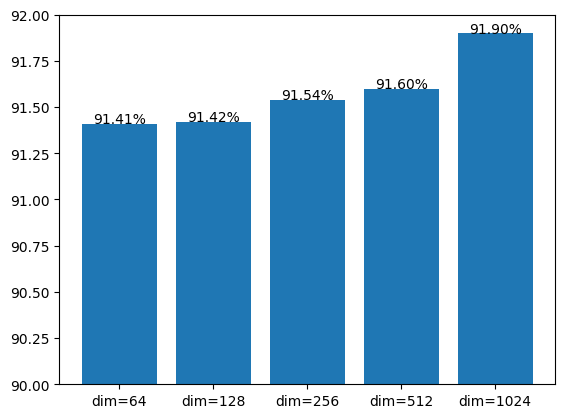

In [17]:
labels = ["dim=64", "dim=128", "dim=256", "dim=512", "dim=1024"]
acc_values = [evaluate(model, test_loader) for model in [model64, model128, model256, model512, model1024]]

# 막대 그래프 그리기
plt.bar(range(5), acc_values)

# X축 레이블 설정
plt.xticks(range(5), labels)

# Y축 범위 설정
plt.ylim(90, 92)

# 막대 상단에 값 표시
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.001, f"{v:.2f}%", ha="center", fontsize=10)

plt.show()

레이어의 차원 수가 커질수록 모델의 성능이 향상되는 모습을 보입니다.

이를 보면 무조건 차원 수를 높이는 것이 좋아보일 수도 있지만 그렇진 않습니다. 차원 수를 높였을 때 가질 수 있는 부작용은 아래와 같습니다.

1. **계산 비용 증가** : 레이어의 파라미터 수가 증가하면서 계산량이 많아져 시간이 오래 걸릴 수 있습니다. 1%의 성능을 얻기 위해 1달을 더 학습해야 한다고 하면 곤란할 수도 있겠죠?
2. **과적합 가능성 증가** : 레이어의 차원 수가 늘어나면 훈련 셋에 대한 정확도는 오르지만 오히려 테스트셋에 대한 정확도가 떨어지는 과적합이 발생할 수 있습니다. 이는 모델이 너무 좋은 표현력을 갖게 되어 훈련셋에 특화된 패턴을 학습하게 되면서 생길 수 있는 문제입니다.

이런 점들을 고려하여 다양한 차원 수를 설정해서 모델을 학습해본 뒤, 가장 적절한 차원 수를 선택하는 것이 중요합니다!

## 2. 레이어 깊이

현재는 2개의 Dense layer를 사용하고 있습니다. 레이어의 수를 늘리면 어떨까요?

In [18]:
class DepthNN(nn.Module):
    def __init__(self, depth):
        super(DepthNN, self).__init__()
        dim = 256
        self.layers = [
            nn.Linear(28*28, dim),
            nn.ReLU()
        ]
        for d in range(depth-1):
            self.layers.append(nn.Linear(dim, dim//2))
            self.layers.append(nn.ReLU())
            dim //= 2

        self.layers.append(nn.Linear(dim, 10))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 28x28 이미지를 1차원 벡터로 변환
        x = self.layers(x)
        return x

depth3model = DepthNN(3)
depth4model = DepthNN(4)

In [19]:
training(depth3model, train_loader)

Epoch 1, Loss: 2.0647
Epoch 2, Loss: 0.4596
Epoch 3, Loss: 0.3754
Epoch 4, Loss: 0.2667
Epoch 5, Loss: 0.6726
Done!


In [20]:
training(depth4model, train_loader)

Epoch 1, Loss: 2.3038
Epoch 2, Loss: 1.9863
Epoch 3, Loss: 0.8574
Epoch 4, Loss: 0.3189
Epoch 5, Loss: 0.3503
Done!


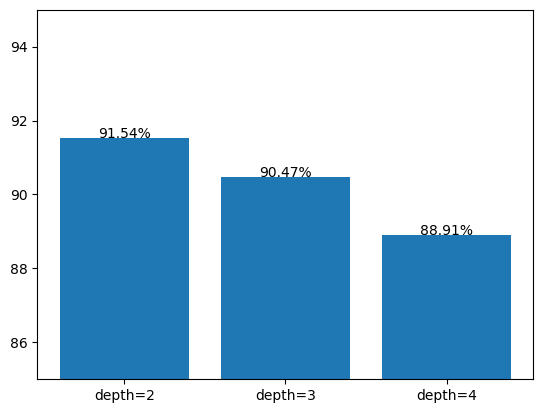

In [21]:
labels = ["depth=2", "depth=3", "depth=4"]
acc_values = [
    evaluate(model, test_loader) for model in [model256, depth3model, depth4model]
]

# 막대 그래프 그리기
plt.bar(range(3), acc_values)

# X축 레이블 설정
plt.xticks(range(3), labels)

# Y축 범위 설정
plt.ylim(85, 95)

# 막대 상단에 값 표시
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.001, f"{v:.2f}%", ha="center", fontsize=10)

plt.show()

레이어의 깊이가 깊어질수록 정확도가 떨어지는 모습을 보입니다.

레이어의 깊이 역시 실험을 통해 적당한 깊이를 찾는 것이 좋습니다.

다른 데이터에서는 또 다른 결과가 나올 수 있기 때문이죠.

## 3. 레이어 추가

모델의 성능을 높일 수 있는 특정 레이어들을 추가하는 것도 방법입니다.

* Dropout : '학습 중'에 의도적으로 일부 레이어를 꺼서 모델이 특정 패턴을 외우지 않도록 변칙을 줍니다.
  * 모델이 훈련셋에 "과적합"되는 것을 막는데 사용됩니다.
  * 과적합이란? : 모델이 훈련셋에 지나치게 익숙해져 테스트셋에 성능이 약해지는 것을 말합니다.
* LayerNormalization : 모델 레이어의 출력값을 정규화하여 학습을 안정화합니다.

In [22]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)  # 레이어의 차원 수(dim)을 조절
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 28x28 이미지를 1차원 벡터로 변환
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

dropout_model0 = DropoutNN(0.0)
dropout_model1 = DropoutNN(0.1)
dropout_model2 = DropoutNN(0.2)
dropout_model3 = DropoutNN(0.3)
dropout_model4 = DropoutNN(0.4)

In [23]:
training(dropout_model0, train_loader, epochs=10)

Epoch 1, Loss: 0.8133
Epoch 2, Loss: 0.3281
Epoch 3, Loss: 0.4678
Epoch 4, Loss: 0.5791
Epoch 5, Loss: 0.2053
Epoch 6, Loss: 0.2152
Epoch 7, Loss: 0.2865
Epoch 8, Loss: 0.1762
Epoch 9, Loss: 0.2349
Epoch 10, Loss: 0.2658
Done!


In [24]:
training(dropout_model1, train_loader, epochs=10)

Epoch 1, Loss: 0.4916
Epoch 2, Loss: 0.4093
Epoch 3, Loss: 0.5741
Epoch 4, Loss: 0.5317
Epoch 5, Loss: 0.3361
Epoch 6, Loss: 0.2921
Epoch 7, Loss: 0.2171
Epoch 8, Loss: 0.1340
Epoch 9, Loss: 0.1082
Epoch 10, Loss: 0.1368
Done!


In [25]:
training(dropout_model2, train_loader, epochs=10)

Epoch 1, Loss: 0.6611
Epoch 2, Loss: 0.3750
Epoch 3, Loss: 0.2507
Epoch 4, Loss: 0.2426
Epoch 5, Loss: 0.3633
Epoch 6, Loss: 0.3567
Epoch 7, Loss: 0.1930
Epoch 8, Loss: 0.8008
Epoch 9, Loss: 0.4159
Epoch 10, Loss: 0.0943
Done!


In [26]:
training(dropout_model3, train_loader, epochs=10)

Epoch 1, Loss: 0.6174
Epoch 2, Loss: 0.5181
Epoch 3, Loss: 0.2926
Epoch 4, Loss: 0.1814
Epoch 5, Loss: 0.3311
Epoch 6, Loss: 0.3264
Epoch 7, Loss: 0.2315
Epoch 8, Loss: 0.3273
Epoch 9, Loss: 0.6118
Epoch 10, Loss: 0.2273
Done!


In [27]:
training(dropout_model4, train_loader, epochs=10)

Epoch 1, Loss: 0.6315
Epoch 2, Loss: 0.5126
Epoch 3, Loss: 0.4426
Epoch 4, Loss: 0.2375
Epoch 5, Loss: 0.4336
Epoch 6, Loss: 0.2723
Epoch 7, Loss: 0.1107
Epoch 8, Loss: 0.3407
Epoch 9, Loss: 0.4477
Epoch 10, Loss: 0.5870
Done!


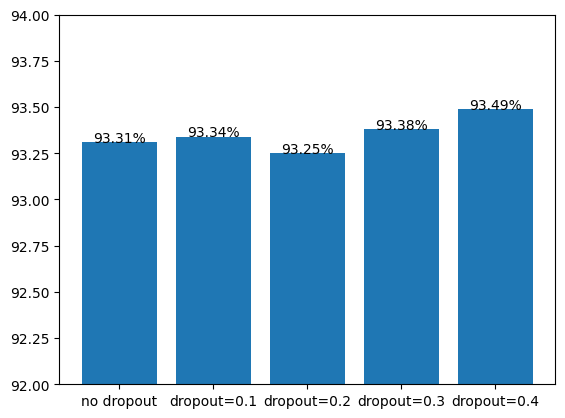

In [28]:
labels = ["no dropout", "dropout=0.1", "dropout=0.2", "dropout=0.3", "dropout=0.4"]
acc_values = [
    evaluate(model, test_loader) for model in [dropout_model0, dropout_model1, dropout_model2, dropout_model3, dropout_model4]
]

# 막대 그래프 그리기
plt.bar(range(5), acc_values)

# X축 레이블 설정
plt.xticks(range(5), labels)

# Y축 범위 설정
plt.ylim(92, 94)

# 막대 상단에 값 표시
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.001, f"{v:.2f}%", ha="center", fontsize=10)

plt.show()

dropout_rate=0.3일 때 가장 좋은 성능이 나왔습니다.

과적합 방지를 통해 모델의 성능이 개선된 모습입니다.

이번엔 LayerNormalization 레이어도 추가해 보겠습니다.

LayerNormalization은 Dense 레이어 중간에 추가해 줍니다.

In [41]:
class LayerNormNN(nn.Module):
    def __init__(self):
        super(LayerNormNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)  # 레이어의 차원 수(dim)을 조절
        self.layer_norm = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 28x28 이미지를 1차원 벡터로 변환
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

norm_model = LayerNormNN()

In [42]:
training(norm_model, train_loader, epochs=10)

Epoch 1, Loss: 0.2007
Epoch 2, Loss: 0.3266
Epoch 3, Loss: 0.1744
Epoch 4, Loss: 0.3851
Epoch 5, Loss: 0.0202
Epoch 6, Loss: 0.2055
Epoch 7, Loss: 0.0635
Epoch 8, Loss: 0.0663
Epoch 9, Loss: 0.0328
Epoch 10, Loss: 0.1284
Done!


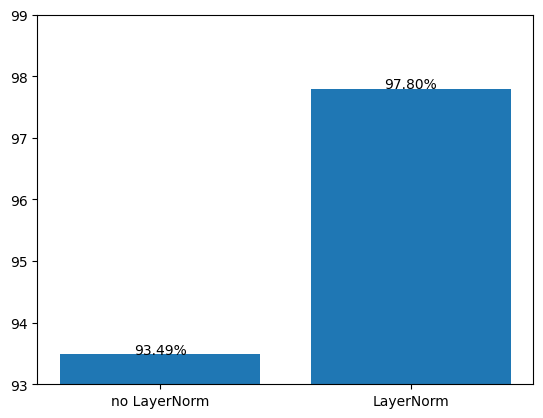

In [32]:
labels = ["no LayerNorm", "LayerNorm"]
acc_values = [evaluate(model, test_loader) for model in [dropout_model4, norm_model]]

# 막대 그래프 그리기
plt.bar(range(2), acc_values)

# X축 레이블 설정
plt.xticks(range(2), labels)

# Y축 범위 설정
plt.ylim(93, 99)

# 막대 상단에 값 표시
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.001, f"{v:.2f}%", ha="center", fontsize=10)

plt.show()

LayerNormalization을 적용한 모델과 적용하지 않은 모델의 정확도가 4% 가량 차이 납니다!

LayerNormalization이 확실히 학습에 긍정적인 효과를 줬네요!

성능이 점점 올라가는 것을 보니 재밌지 않나요?

## Convolution 레이어 사용

지금까지는 이미지를 일자로 쭉 편 뒤(Flatten)에 Dense 레이어를 적용하여 이미지를 처리했습니다.

하지만 그 과정에서 이미지의 원래 모습을 유지하지 못하게 되는 문제가 있습니다. 이러면 모델이 이미지를 온전히 이해하기 힘들 수도 있겠죠?

Convolution 레이어를 사용하면 이미지의 형태를 유지하면서도 더 효율적으로 학습을 수행할 수 있습니다.

Convolution 레이어를 사용해 모델을 개선해 봅시다.

In [43]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.norm1 = nn.BatchNorm2d(256)
        self.norm2 = nn.BatchNorm2d(128)
        self.norm3 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.norm1(self.conv1(x))
        x = self.relu(self.pool(x))

        x = self.norm2(self.conv2(x))
        x = self.relu(self.pool(x))

        x = self.norm3(self.conv3(x))
        x = self.relu(self.pool(x))

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

conv_model = ConvNN()

In [44]:
training(conv_model, train_loader, epochs=10)

Epoch 1, Loss: 0.3184
Epoch 2, Loss: 0.2524
Epoch 3, Loss: 0.1186
Epoch 4, Loss: 0.1007
Epoch 5, Loss: 0.0837
Epoch 6, Loss: 0.1555
Epoch 7, Loss: 0.1808
Epoch 8, Loss: 0.0554
Epoch 9, Loss: 0.1087
Epoch 10, Loss: 0.0671
Done!


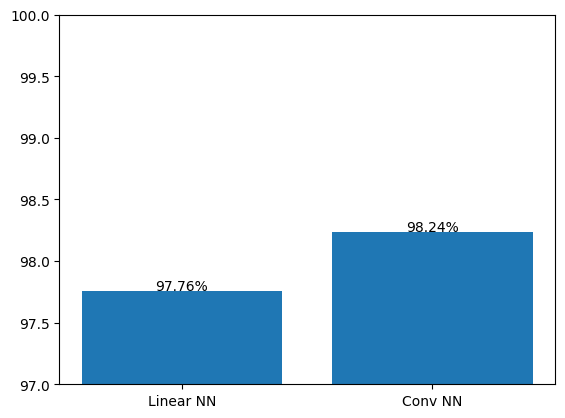

In [45]:
labels = ["Linear NN", "Conv NN"]
acc_values = [evaluate(model, test_loader) for model in [norm_model, conv_model]]

# 막대 그래프 그리기
plt.bar(range(2), acc_values)

# X축 레이블 설정
plt.xticks(range(2), labels)

# Y축 범위 설정
plt.ylim(97, 100)

# 막대 상단에 값 표시
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.001, f"{v:.2f}%", ha="center", fontsize=10)

plt.show()

정확도가 98.24%까지 올라왔어요! 😎

이러다 100% 찍는거 아닌가요?